<a href="https://colab.research.google.com/github/txnf/autobonk/blob/main/autobonk_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import glob
import uuid
import tables
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl
import json
import pycocotools

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['xtick.major.pad']=8

mpl.rcParams['xtick.labelsize']=10
mpl.rcParams['ytick.labelsize']=10
mpl.rcParams['ytick.major.pad']=8
mpl.rcParams['font.size']=12


In [3]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
file_list = glob.glob('/content/gdrive/MyDrive/assets/autobonk_sources/*.png')

In [8]:
len(file_list)

2351

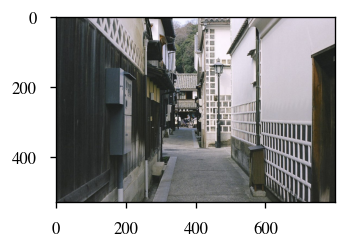

In [24]:
image = cv2.imread(file_list[14])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=120)
ax.imshow(image)

In [25]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [39]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

/content
fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done


In [40]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-m4__ir43
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-m4__ir43
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [41]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.
0.6.0


In [42]:
import os

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [43]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


:

In [44]:
import os

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


In [45]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [46]:
import os

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [47]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/content/GroundingDINO
final text_encoder_type: bert-base-uncased


In [49]:
SAM_ENCODER_VERSION = "vit_h"

In [50]:
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

In [51]:
import pycocotools

In [124]:
# AUTOBONK source code

def extract_masked_pixels(image, mask):
    x,y,w,h = np.array(mask['bbox'], dtype='int')
    seg = mask['segmentation']
    print(f"seg.shape = {seg.shape}")
    print(f"bbox = {mask['bbox']}")
    im = np.zeros((h, w, 3), dtype='uint8')

    msk_bb = seg[y:y+h,x:x+w]
    im[:,:,0][msk_bb] = image[y:y+h,x:x+w,0][msk_bb]
    im[:,:,1][msk_bb] = image[y:y+h,x:x+w,1][msk_bb]
    im[:,:,2][msk_bb] = image[y:y+h,x:x+w,2][msk_bb]
    # im[:,:,3][msk_bb] = 255

    # return seg
    # print(im.shape)
    return im

def extract_detections(image, masks):
    sort_order = np.argsort([m['area'] for m in masks])[::-1]

    extract_ims = []
    for msk in np.array(masks)[sort_order]:
        extract_ims.append(extract_masked_pixels(image, msk))

    return extract_ims

def show_grid(image, masks, grd=(6,6)):
    fig,ax = plt.subplots(1,1,figsize=(4,4), dpi=100)
    ax.imshow(image)

    fig, axs = plt.subplots(grd[0], grd[1], figsize=(5,5), dpi=100)
    axs  = axs.flatten()

    for i, imi in enumerate(extract_detections(image, masks)):
        if i >= len(axs):
            break
        print(f"imi.shape  = {imi.shape}")
        axs[i].imshow(imi, aspect='equal')
        # axs[i].axis('off')

    fig.set_facecolor('lightgray')


In [91]:
# prompt: how to decode a base64 string to byte array if the base64 is utf-8 encoded

import base64
"hello""

SyntaxError: ignored

In [1]:
import pycocotools.mask as mask_utils
import collections as coll
import json
import uuid
import base64
import gzip
import itertools as it
import functools as ft
import operator as op



def encode_segmentation_array(arr):
  enc = mask_utils.encode(arr)
  b64enc = base64.b64encode(enc['counts'])
  strenc = b64enc.decode('utf-8')
  return strenc

def decode_segmentation_array(shape, rle_segmentation_b64):
  pass



file_name = '/content/gdrive/MyDrive/asset_processed/result_list.json.gz'
asset_dir = '/content/gdrive/MyDrive/assets/autobonk_sources/'

def show_segmentation_results(seg, asset_dir):
  source_file_name = f"{seg['source_file_id']}.png"
  source_file_path = os.path.join(asset_dir, source_file_name)

  # read source image
  print(f"reading {source_file_name}")
  print(seg)
  image = cv2.imread(source_file_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_shape = image.shape

  print(f"db size = {seg['source_file_shape']} image shape {image_shape}")

  # now extract masks
  # bboxs = [mi['bbox'] for mi in seg['']]
  bboxs, segs = [],[]
  for msk in seg['masks']:
    msk_id = msk['mask_id']
    bbox = msk['bbox']
    area = msk['area']
    point_coords = msk['point_coords']
    stability_score = msk['stability_score']
    predicted_iou = msk['predicted_iou']

    rle_segmentation_b64 = msk['rle_segmentation_b64']

    b64dec = base64.b64decode(rle_segmentation_b64)
    segmentation = mask_utils.decode({'size': image_shape, 'counts': b64dec})

    msk['segmentation'] = segmentation

  show_grid(image, seg['masks'], grd=(4,4))







n=12
with gzip.open(file_name, 'rt', encoding='utf8') as f:
  line = next(it.islice(f, n, None, n))
  d = json.loads(line.strip())
  show_segmentation_results(d, asset_dir)


FileNotFoundError: ignored

In [ ]:
# prompt: write a python code that transforms a list of dictionaries into a dictionary of lists use default_dict and works for all key value

from collections import defaultdict
data = [{'a': 1, 'b': 2}, {'a': 3, 'c': 4}]
d = defaultdict(list)
for x in data:
  for k, v in x.items():
    d[k].append(v)
print(d)


In [68]:
1+1

2

In [84]:
import pycocotools.mask as mask_utils
import json
import uuid
import base64

def process_file(file_name):
  basename = os.path.basename(file_name).split('.')[0]
  print(f"reading {basename}")
  image = cv2.imread(file_name)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_shape = image.shape

  # segment image
  masks = mask_generator.generate(image)

  # filter masks
  area_threshold = 900 #px.sq approx 30 pixels on a side
  min_side = 10

  pre_filter_masks = len(masks)

  print(f"filtering masks to area > {area_threshold}")
  masks = [msk for msk in masks if msk['bbox'][2] * msk['bbox'][3] > area_threshold]
  masks = [msk for msk in masks if msk['bbox'][2] >= min_side and msk['bbox'][3] >= min_side]

  post_filter_masks = len(masks)
  print(f"{post_filter_masks}/{pre_filter_masks} passed filter")

  # ims = extract_detections(image, masks)

  def msk2str(segmentation):
    msk = mask_utils.encode(segmentation)
    b64enc = base64.b64encode(msk['counts'])
    return b64enc

  result = {
    'source_file_id' : basename,
    'source_file_shape' : image_shape,
    'number_of_masks' : len(masks),
    'masks' : [
      {
        'mask_id' : uuid.uuid4().hex,
        'source_file_id' : basename,
        'source_file_shape' : image_shape,
        'bbox' : msk['bbox'],
        'area' : msk['area'],
        'point_coords' : msk['point_coords'],
        'predicted_iou' : msk['predicted_iou'],
        'stability_score' : msk['stability_score'],
        'rle_segmentation_b64' : msk2str(msk['segmentation'])
      } for msk in masks ]
  }

  return result



def process_files(file_list, outdir):
  result_list = []
  with open(os.path.join(outdir, 'result_list.json'), 'a') as rf:
    for fn in tqdm(file_list):
        result = process_file(fn)
        # print(f"{json.dumps(result)}")

        # save result mask images

        rf.write(json.dumps(result) + '\n')

        # print(f"result: {result}")
        result_list.append(result)

  return result_list

result = process_file(file_list[11])


# result_list = process_files(file_list[:], '/content/gdrive/MyDrive/asset_processed')

reading e7795586a9f341e18877efe4785f1cc3
filtering masks to area > 900
11/32 passed filter
processing masks
{'size': [226, 200], 'counts': b'ak`0:d66L4L4M2N2N2N2O0O2N2O0O2O0O1000001O0VOiNhKX1Q5000000O101O00001N100O2O1N1OTOQOhKm0Z4SOfKk0Z5N2N3M3L4L4J`Pb0'}
(226, 200) : b'YWtgMDpkNjZMNEw0TTJOMk4yTjJPME8yTjJPME8yTzBPMTAwMDAwMU8wVk9pTmhLWDFRNTAwMDAwME8xMDFPMDAwMDFOMTAwTzJPMU4xT1RPUU9oS20wWjRTT2ZLazBaNU4yTjNNM0w0TDRKYFBiMA=='
b64dec = b'ak`0:d66L4L4M2N2N2N2O0O2N2O0O2O0O1000001O0VOiNhKX1Q5000000O101O00001N100O2O1N1OTOQOhKm0Z4SOfKk0Z5N2N3M3L4L4J`Pb0'
enc.shape = (226, 200)


AssertionError: ignored

In [ ]:
# prompt: using file.write so that the output is flushed

file.write(json.dumps(result) + '\n')


{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False]]),
 'area': 28423,
 'bbox': [733, 79, 66, 449],
 'predicted_iou': 1.0121840238571167,
 'point_coords': [[737.5, 256.71875]],
 'stability_score': 0.9917355179786682,
 'crop_box': [0, 0, 800, 530]}

['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box']
{'segmentation': {'size': [530, 800], 'counts': b'i_k;4c9OPH`1n1cNo3V5oK_KNYOnLX8S3i4N10000O100O100O100O100O100O100O100O011O0O10000O100O1O100O100O10000O100O100O1O100O10000O10000O100O10000O1O1O10000O100O100O10000aM'}, 'area': 28423, 'bbox': [733, 79, 66, 449], 'predicted_iou': 1.0121840238571167, 'point_coords': [[737.5, 256.71875]], 'stability_score': 0.9917355179786682, 'crop_box': [0, 0, 800, 530]}
['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box']
{'segmentation': {'size': [530, 800], 'counts': b'0``020000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001O000000O100000000001O000000O10000O10000001O0000000000000000000000000000000000000000000000000000000000000000000000000000000000O100000000001O000000000000000000000000000000000000000000000000000000001O000000O100000000000000O

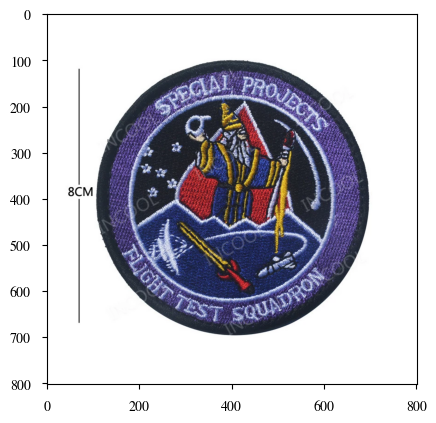

In [54]:
n = 21
im = cv2.imread(file_list[n])
im = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)
fig, ax = plt.subplots(1,1)
image_shape = image.shape
masks = mask_generator.generate(image)
for mask in masks:
  enc = mask_utils.encode(mask['segmentation'])
  mask['segmentation'] = enc
  print(list(mask.keys()))
  print(mask)

ax.imshow(im)

In [ ]:
from pycocotools.coco

ImportError: ignored

In [ ]:
import pycocotools.mask as mask_utils

In [ ]:
raw = masks[0]['segmentation']
encoding = mask_utils.encode(masks[0]['segmentation'])
encoding

{'size': [530, 800],
 'counts': b'i_k;4c9OPH`1n1cNo3V5oK_KNYOnLX8S3i4N10000O100O100O100O100O100O100O100O011O0O10000O100O1O100O100O10000O100O100O1O100O10000O10000O100O10000O1O1O10000O100O100O10000aM'}

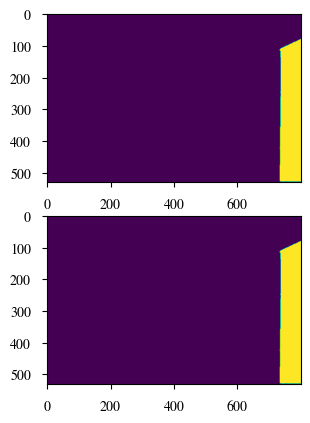

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.imshow(raw)
ax2.imshow(mask_utils.decode(encoding))

In [ ]:
import
sys.getsizeof(encoding)

232

In [ ]:
class Mask(tables.IsDescription):
  mask_name = tables.StringCol(32)
  parent_file_name = tables.StringCol(32)
  bbox = tables.Int32Col(shape=(4,))
  predicted_iou = tables.Float32Col()
  stability_score = tables.Float32Col()

def process_files(file_list, outfile):
    print(f"opening {outfile}")
    with tables.open_file(outfile, 'w') as h5file:
        # create group for each image
        mask_image_group = h5file.create_group('/', 'mask_images')
        mask_table_group = h5file.create_group('/', 'mask_tables')
        mask_table = h5file.create_table(mask_table_group, 'mask', Mask, 'Mask Data')

        for fn in tqdm(file_list):
            basename = os.path.basename(fn).split('.')[0]
            print(f"reading {basename}")
            image = cv2.imread(fn)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            masks = mask_generator.generate(image)
            ims = extract_detections(image, masks)

            print(f"extracted {len(masks)} masks")

            # create table for each image
            for im, msk in zip(ims, masks):
              parent_file_name = basename
              mask_name = uuid.uuid4().hex

              # write data for each mask to table
              mask_row = mask_table.row
              mask_row['mask_name'] = 'h' + mask_name
              mask_row['parent_file_name'] = 'h' + parent_file_name
              mask_row['bbox'] = np.array(msk['bbox'], dtype='int')
              mask_row['predicted_iou'] = msk['predicted_iou']
              mask_row['stability_score'] = msk['stability_score']
              mask_row.append()

              h5file.create_array(mask_image_group, 'h' + mask_name, im, 'Image')

            mask_table.flush()


NameError: ignored

In [ ]:
process_files(file_list[:1000], '/content/gdrive/MyDrive/asset_processed/test.h5')

51707


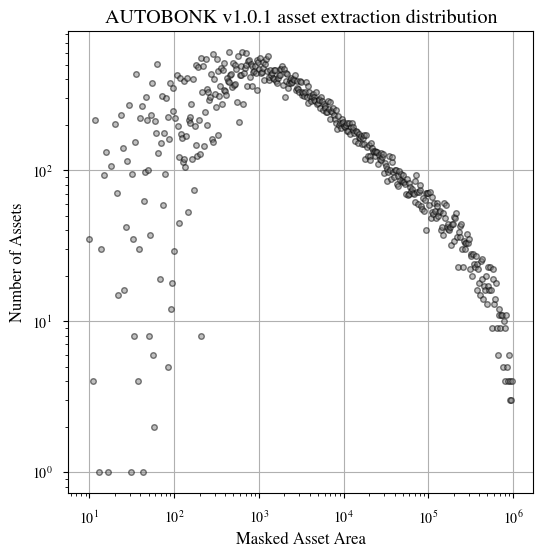

In [ ]:
# prompt: write a python function to load an image file from file_list and the h5file created in process_files and show the masks for each of those images

def show_masks(file_name, h5file):
    with tables.open_file(h5file, 'r') as h5file:
        mask_table = h5file.root.mask_tables.mask

        mask_image_group = h5file.root.mask_images
        parent_file_name = 'h' + os.path.basename(file_name).split('.')[0]



        rows = mask_table.read()
        bboxes = rows['bbox']
        areas = [w*h for x,y,w,h in bboxes]

        fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=100)

        bins = np.logspace(1,6,500)


        counts, bins = np.histogram(areas, bins=bins)
        ax.plot(bins[:-1],counts, marker='o', mec='k', mfc='grey', ms=4, lw=0, alpha=0.5)
        ax.grid(True)

        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel('Masked Asset Area')
        ax.set_ylabel("Number of Assets")
        ax.set_title('AUTOBONK v1.0.1 asset extraction distribution')
        threshold_area = 900
        print(f"{np.sum(np.array(areas) > threshold_area)}")


        # eeax.set_xlim(0, 500*500)
        # print(mask_image_group
        # arrs = h5file.root.mask_images._v_children.values()

        # for arr in arrs[:10]:
        #   print(arr.name, arr.shape)
        # # print(f"searching for masks with parent_file_name = {parent_file_name}")

        # masks = mask_table.where('parent_file_name == "' + parent_file_name + '"')
        # print(len(list(masks)))
        # print(f"{len(masks)} matching {parent_file_name} found")

        # image = cv2.imread(file_name)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=100)
        # ax.imshow(image)


show_masks(file_list[60] , '/content/gdrive/MyDrive/asset_processed/test.h5')

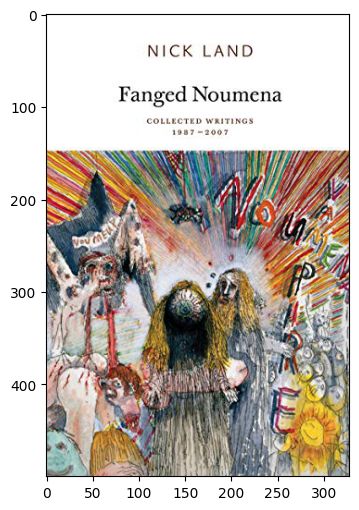

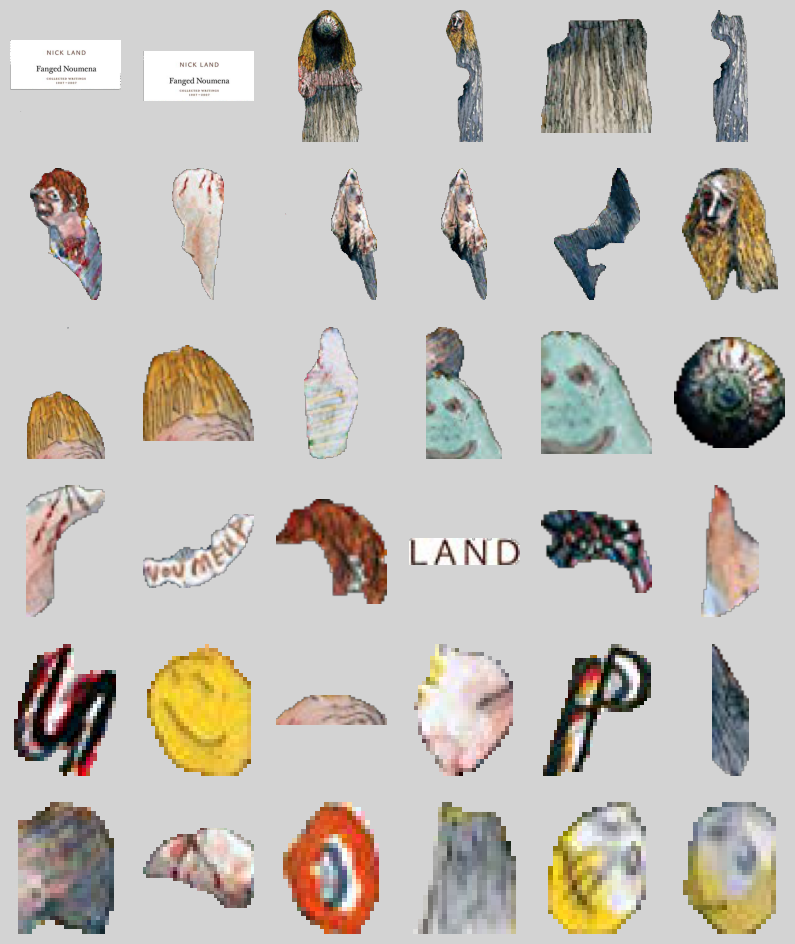

In [ ]:

image = cv2.imread(file_list[1782])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=100)
ax.imshow(image)
masks = mask_generator.generate(image)

show_grid(image, masks)

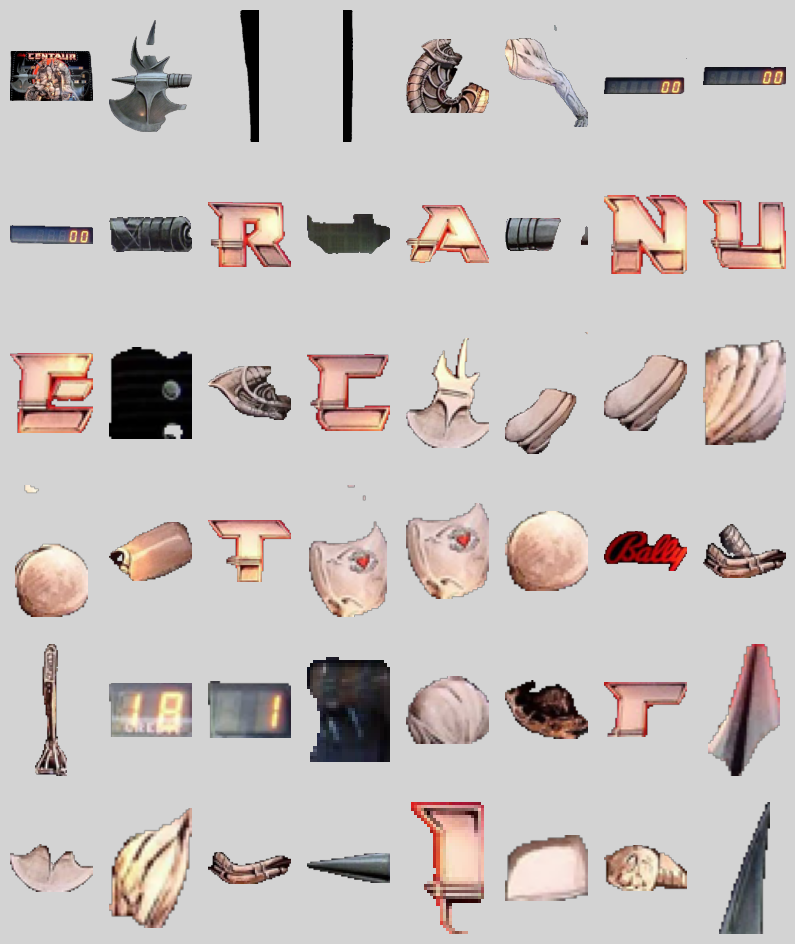

In [ ]:
show_grid(image, masks, grd=(6,8))

In [ ]:
list(masks[5].keys())

['segmentation',
 'area',
 'bbox',
 'predicted_iou',
 'point_coords',
 'stability_score',
 'crop_box']

In [ ]:
with tables.open_file('/content/gdrive/MyDrive/asset_processed/test.h5', 'r') as h5file:
    for row in h5file.root.mask_tables.mask:
        print(str(row['mask_name'].decode('utf-8')), row['parent_file_name'].decode('utf-8'),
              row['bbox'])

    for im in h5file.root.mask_images:
        print(im.name, im.shape)

hfd9bd6c117a042b185ddee5e58213e3 h2f5bcb9271eb45a9a732cb54f659e09 [ 33  87 288 299]
h29b305a25fc44770af89dd24f0e6516 h2f5bcb9271eb45a9a732cb54f659e09 [  2  33 350 466]
h13fcc29e8b504f56bf9fd60675e6562 h2f5bcb9271eb45a9a732cb54f659e09 [  1   0 352  31]
hb8997743cf8f400e9fa69dbf7a815db h2f5bcb9271eb45a9a732cb54f659e09 [215 412  19  24]
hf77ed5b70ad74e648d4267667ff0bec h2f5bcb9271eb45a9a732cb54f659e09 [194 412  19  24]
h62e9bc5610324ae68647f5e73c863bd h2f5bcb9271eb45a9a732cb54f659e09 [252 412  26  24]
h8e27e46edfb245ecb0a8d8819da862e h2f5bcb9271eb45a9a732cb54f659e09 [238 447  26  24]
he40f5e973b8f4429867071c7323f46d h2f5bcb9271eb45a9a732cb54f659e09 [131  87  93 153]
h9401e7ab92ac443785e334f4d46e40c h2f5bcb9271eb45a9a732cb54f659e09 [164 447  26  24]
hcdec064f52d64a46b3ca22a4cf27daf h2f5bcb9271eb45a9a732cb54f659e09 [101 403  28  35]
h1741953749604e31b93f8bca593cdb3 h2f5bcb9271eb45a9a732cb54f659e09 [ 44 405  23  31]
h7afedbfc0d8348f5a0fe18a55eb81fe h2f5bcb9271eb45a9a732cb54f659e09 [ 57 454  

In [ ]:
def process_images(path, outdir, restart_file=None):
  file_list = os.listdir(path)

  # check if outdir exists
  if not os.path.isdir(outdir):
    os.mkdir(outdir)

  if restart_file is None:
    # if restart is None then initialize it
    restart = dict(
        infile_list = file_list,
        outdir = outdir
    )

In [ ]:
import tables

In [ ]:
def process_masks(image, masks):
  # store segmentation as a boolean numpy array




def print_mask_info(image, masks):
    for i,msk in enumerate(masks):
      print(f"mask {i}")
      for k,v in msk.items():
        if k == 'segmentation':
          print(f"\t{k}: {v.shape}")
          continue
        print(f"\t{k}: {v}")
print_mask_info(image, masks)

mask 0
	segmentation: (700, 500)
	area: 228207
	bbox: [1, 0, 497, 699]
	predicted_iou: 1.0253674983978271
	point_coords: [[351.5625, 689.0625]]
	stability_score: 0.9901425838470459
	crop_box: [0, 0, 500, 700]
mask 1
	segmentation: (700, 500)
	area: 115568
	bbox: [122, 107, 260, 592]
	predicted_iou: 1.0247334241867065
	point_coords: [[335.9375, 557.8125]]
	stability_score: 0.9897865056991577
	crop_box: [0, 0, 500, 700]
mask 2
	segmentation: (700, 500)
	area: 5234
	bbox: [191, 107, 110, 76]
	predicted_iou: 1.0066121816635132
	point_coords: [[210.9375, 120.3125]]
	stability_score: 0.982409656047821
	crop_box: [0, 0, 500, 700]
mask 3
	segmentation: (700, 500)
	area: 66916
	bbox: [122, 239, 260, 380]
	predicted_iou: 1.003362774848938
	point_coords: [[132.8125, 317.1875]]
	stability_score: 0.9589720964431763
	crop_box: [0, 0, 500, 700]
mask 4
	segmentation: (700, 500)
	area: 7195
	bbox: [200, 142, 97, 119]
	predicted_iou: 0.9999921321868896
	point_coords: [[226.5625, 251.5625]]
	stability_sc